In [5]:
import os, sys

if "adroit" in os.uname()[1]:
    CUSTOM_MODULE_PATH = "/home/jylin/thesis/modules"
else:
    CUSTOM_MODULE_PATH = "/System/Volumes/Data/Users/jesselin/Dropbox/src/thesis/modules"
sys.path.append(CUSTOM_MODULE_PATH)

# custom libraries
from entropy import get_entropy
from my_funcs import *

# usual libraries
import glob
from collections import defaultdict
import argparse
import functools
import time
from tqdm import trange, tqdm
from datetime import datetime
import pickle

# scientific libraries
import numpy as np

# ML libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# Global variables we expect to be set by commandline
DATA_DIR = None
RES_DIR = None
MAX_LOOP_VAR = None
TENSORBOARD_LOG_DIRNAME = None
EXP_NUM = None
TRIAL_NUM = None
EXP_DIR = None
OUTPUT_DATA_DIR = None
_DEFAULT_NUM_SAMPLES = 2048


In [6]:
# jupyter libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
INTERACTION_Kc = np.log(1+ np.sqrt(2))/2

In [4]:
RES_DIR = "/Users/jesselin/Dropbox/src/thesis/final/resources"
DATA_DIR = "/Users/jesselin/Dropbox/src/thesis/final/data"

In [5]:
def process_data(data_filename: str, interaction_K: list, num_samples: int, batch_size: int = 10, num_workers: int = 0):
    """ Takes filename of .npz files for 1D simulations and returns the DataLoader object """
    dataset = SpinSequenceDataset(data_filename, interaction_K)
    div, mod = divmod(len(dataset), num_samples)

    # make list of the split proportions
    split_list = [num_samples for x in range(div)]
    split_list.append(mod)

    dataset_after_split = random_split(dataset, split_list)
    train_loader = DataLoader(dataset_after_split[0], batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader

def preprocess_data(exp_dir: str):
    """ Stopgap hack to just select the longest iteration file from
    one of the experiment directories for 2D old_data. Returns path of file and interaction_K """
    search_term = os.path.join(exp_dir, "lattice*.txt")
    raw_file_list = glob.glob(search_term)
    data_sample_filepath = raw_file_list[-1]
    f = data_sample_filepath.split("_")
    temperature_index = f.index("T") + 1
    interaction_K = 1/float(f[temperature_index])

    return data_sample_filepath, interaction_K

In [6]:
def make_dataloader(dataset: SpinSequenceDataset, num_samples: int, batch_size: int = 10, num_workers: int = 0):
    """ Takes dataset and returns the DataLoader object """
    div, mod = divmod(len(dataset), num_samples)

    # make list of the split proportions
    split_list = [num_samples for x in range(div)]
    split_list.append(mod)

    dataset_after_split = random_split(dataset, split_list)
    train_loader = DataLoader(dataset_after_split[0], batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader


In [7]:
def get_hdata(model, dataset, num_samples):
    spin_sequence_list = []
    standard_hidden_sequence_list = []
    whh = model.rnn.weight_hh_l0
    iterable_dataset = iter(dataset)
    for sample in trange(num_samples):
        spin_sequence, _ = next(iterable_dataset)
        numpy_spin_sequence = spin_sequence.detach().squeeze().numpy()
        spin_sequence_list.append(numpy_spin_sequence)
        hidden_sequence = model.record_hidden(spin_sequence)
        standard_hidden_sequence = torch.matmul(whh, hidden_sequence.unsqueeze(-1)).detach().squeeze().numpy()
        standard_hidden_sequence_list.append(standard_hidden_sequence)

    return spin_sequence_list, standard_hidden_sequence_list

In [8]:
def get_interaction_K(resource_filepath):
    basename, file_ext = os.path.splitext(os.path.basename(resource_filepath))
    interaction_K_str = basename[basename.index("K=")+2:]
    interaction_K_str = interaction_K_str.strip("[]").split(" ")
    interaction_K = [float(s) for s in interaction_K_str if s != ""]
    return interaction_K

def get_kfrac(log_dir):
    basename = os.path.basename(log_dir)
    idx = basename.index("kfrac=") + len("kfrac=")
    return basename[idx:]

In [9]:
def get_model(kfrac, hidden_size, trial_num):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn/2d_cluster_data/compiled tight nn"
    search_term = "logs_2D*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    model_dir_dict = {round(float(get_K(f))/INTERACTION_Kc, 2):f for f in raw_file_list}
    checkpoint_dir = os.path.join(model_dir_dict[kfrac], f"hidden_size={hidden_size}/version_{trial_num}/checkpoints")
    checkpoint_basename, = os.listdir(checkpoint_dir)
    checkpoint = os.path.join(checkpoint_dir, checkpoint_basename)
    return IsingRNN_compat.load_from_checkpoint(checkpoint)

In [10]:
def get_spin_file(kfrac):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn_compiled/test_res_dir/compiled tensors"
    search_term = "compiled*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    spin_file_dict = {round(1/float(get_T(f))/INTERACTION_Kc, 2):f for f in raw_file_list}
    return spin_file_dict[kfrac], spin_file_dict

In [11]:
def get_fake_sequence_dataset(input_state_list, list_proportions=None, size=1000) -> zip:
    """ Returns zip of fake sequence, but implements iter so can use in make_dataloader """
    full_tensor = torch.tensor([])

    # find smallest input state
    tmp = [len(i) for i in input_state_list]
    smallest_input_state = input_state_list[np.argmin(tmp)]

    num_repeats = (size // smallest_input_state.shape[-1]) + 1
    for i in range(num_repeats):
        if list_proportions is not None:
            assert np.sum(list_proportions) == 1
            input_state = np.random.choice(input_state_list, p=list_proportions)
        else:
            input_state, = input_state_list
        full_tensor = torch.cat((full_tensor, input_state))

    # crop to size
    full_tensor = full_tensor[:size]

    samples_tensor = torch.empty((1000, size))
    for _ in range(samples_tensor.shape[0]):
        samples_tensor[_] = full_tensor
    fake_dataset = zip(samples_tensor[:,:-1], samples_tensor[:,1:])
    return fake_dataset
def get_state_locations(reduced_hdata, bin_count=20):
    freq, bin_edges = np.histogram(reduced_hdata, bins=bin_count, density=True)
    bin_centers = []
    for i in range(len(bin_edges)-1):
        bc = (bin_edges[i]+bin_edges[i+1])/2
        bin_centers.append(bc)
    freq[freq!=0] = 1
    a = freq*bin_centers
    return sorted(a[a!=0])

In [14]:
model = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/1D/SR/macbook_K=1/hidden_size=1/version_0/checkpoints/epoch=3-step=399.ckpt")
cf_m, cf_e = rnn_generated_corrfunc(1000, model)

100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


In [15]:
filename = "cf_K=1.pickle"
with open(filename, "wb") as f:
    pickle.dump((cf_m, cf_e), f)

In [69]:
model = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/macbook_K=[1.0, 0.1, 0.0]/hidden_size=1/version_2/checkpoints/epoch=4-step=499.ckpt")
interaction_K = [1.0, 0.1, 0.]
filename = f"cf_K={str(interaction_K)}.pickle"


In [70]:
cf_m, cf_e = rnn_generated_corrfunc(1000, model)
with open(filename, "wb") as f:
    pickle.dump((cf_m, cf_e), f)

100%|██████████| 1000/1000 [02:03<00:00,  8.09it/s]


In [22]:
def rnn_generated_corrfunc(num_samples, model):
    generated_samples = []
    for _ in trange(num_samples):
        generated_sequence, hidden_sequence = model.generate_sequence(2048)
        if (generated_sequence[0] == -1.).item():
            generated_sequence *= -1
        generated_sequence = generated_sequence.numpy()
        generated_samples.append(generated_sequence)

    generated_samples = np.array(generated_samples)
    corrfunc_mean, corrfunc_stderr = np.mean(generated_samples, axis=0), np.std(generated_samples, axis=0)/np.sqrt(generated_samples.shape[0])
    return corrfunc_mean, corrfunc_stderr
def mc_corrfunc(np_arr):
    num_samples = np_arr.shape[0]
    corrfunc = np.zeros_like(np_arr)
    for i in range(num_samples):
        for j in range(np_arr.shape[1]):
            corrfunc[i][j] = np_arr[i][0]*np_arr[i][j]
    return np.mean(corrfunc, axis=0), np.std(corrfunc, axis=0)/np.sqrt(corrfunc.shape[0])

In [67]:
mc_data = np.load("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.1 0. ].npz")["sampleData"]
mc_corr, mc_corr_e = mc_corrfunc(mc_data)

filename = f"cf_mc_K={str(interaction_K)}"
with open(filename, "wb") as f:
    pickle.dump((mc_corr, mc_corr_e), f)

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [34]:
interaction_K = 1
mc_data = np.load("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1. 0. 0.].npz")["sampleData"]
mc_corr, mc_corr_e = mc_corrfunc(mc_data)

filename = f"cf_mc_K={str(interaction_K)}"
with open(filename, "wb") as f:
    pickle.dump((mc_corr, mc_corr_e), f)

In [40]:
with open("/Users/jesselin/Dropbox/src/thesis/final/scripts/cf_K=[1.0, 0.1, 0.0].pickle", "rb") as f:
    cf_m, cf_e = pickle.load(f)

In [71]:
with open("/Users/jesselin/Dropbox/src/thesis/final/scripts/cf_mc_K=[1.0, 0.1, 0.0]", "rb") as f:
    mc_corr, mc_corr_e = pickle.load(f)

(0.0, 100.0)

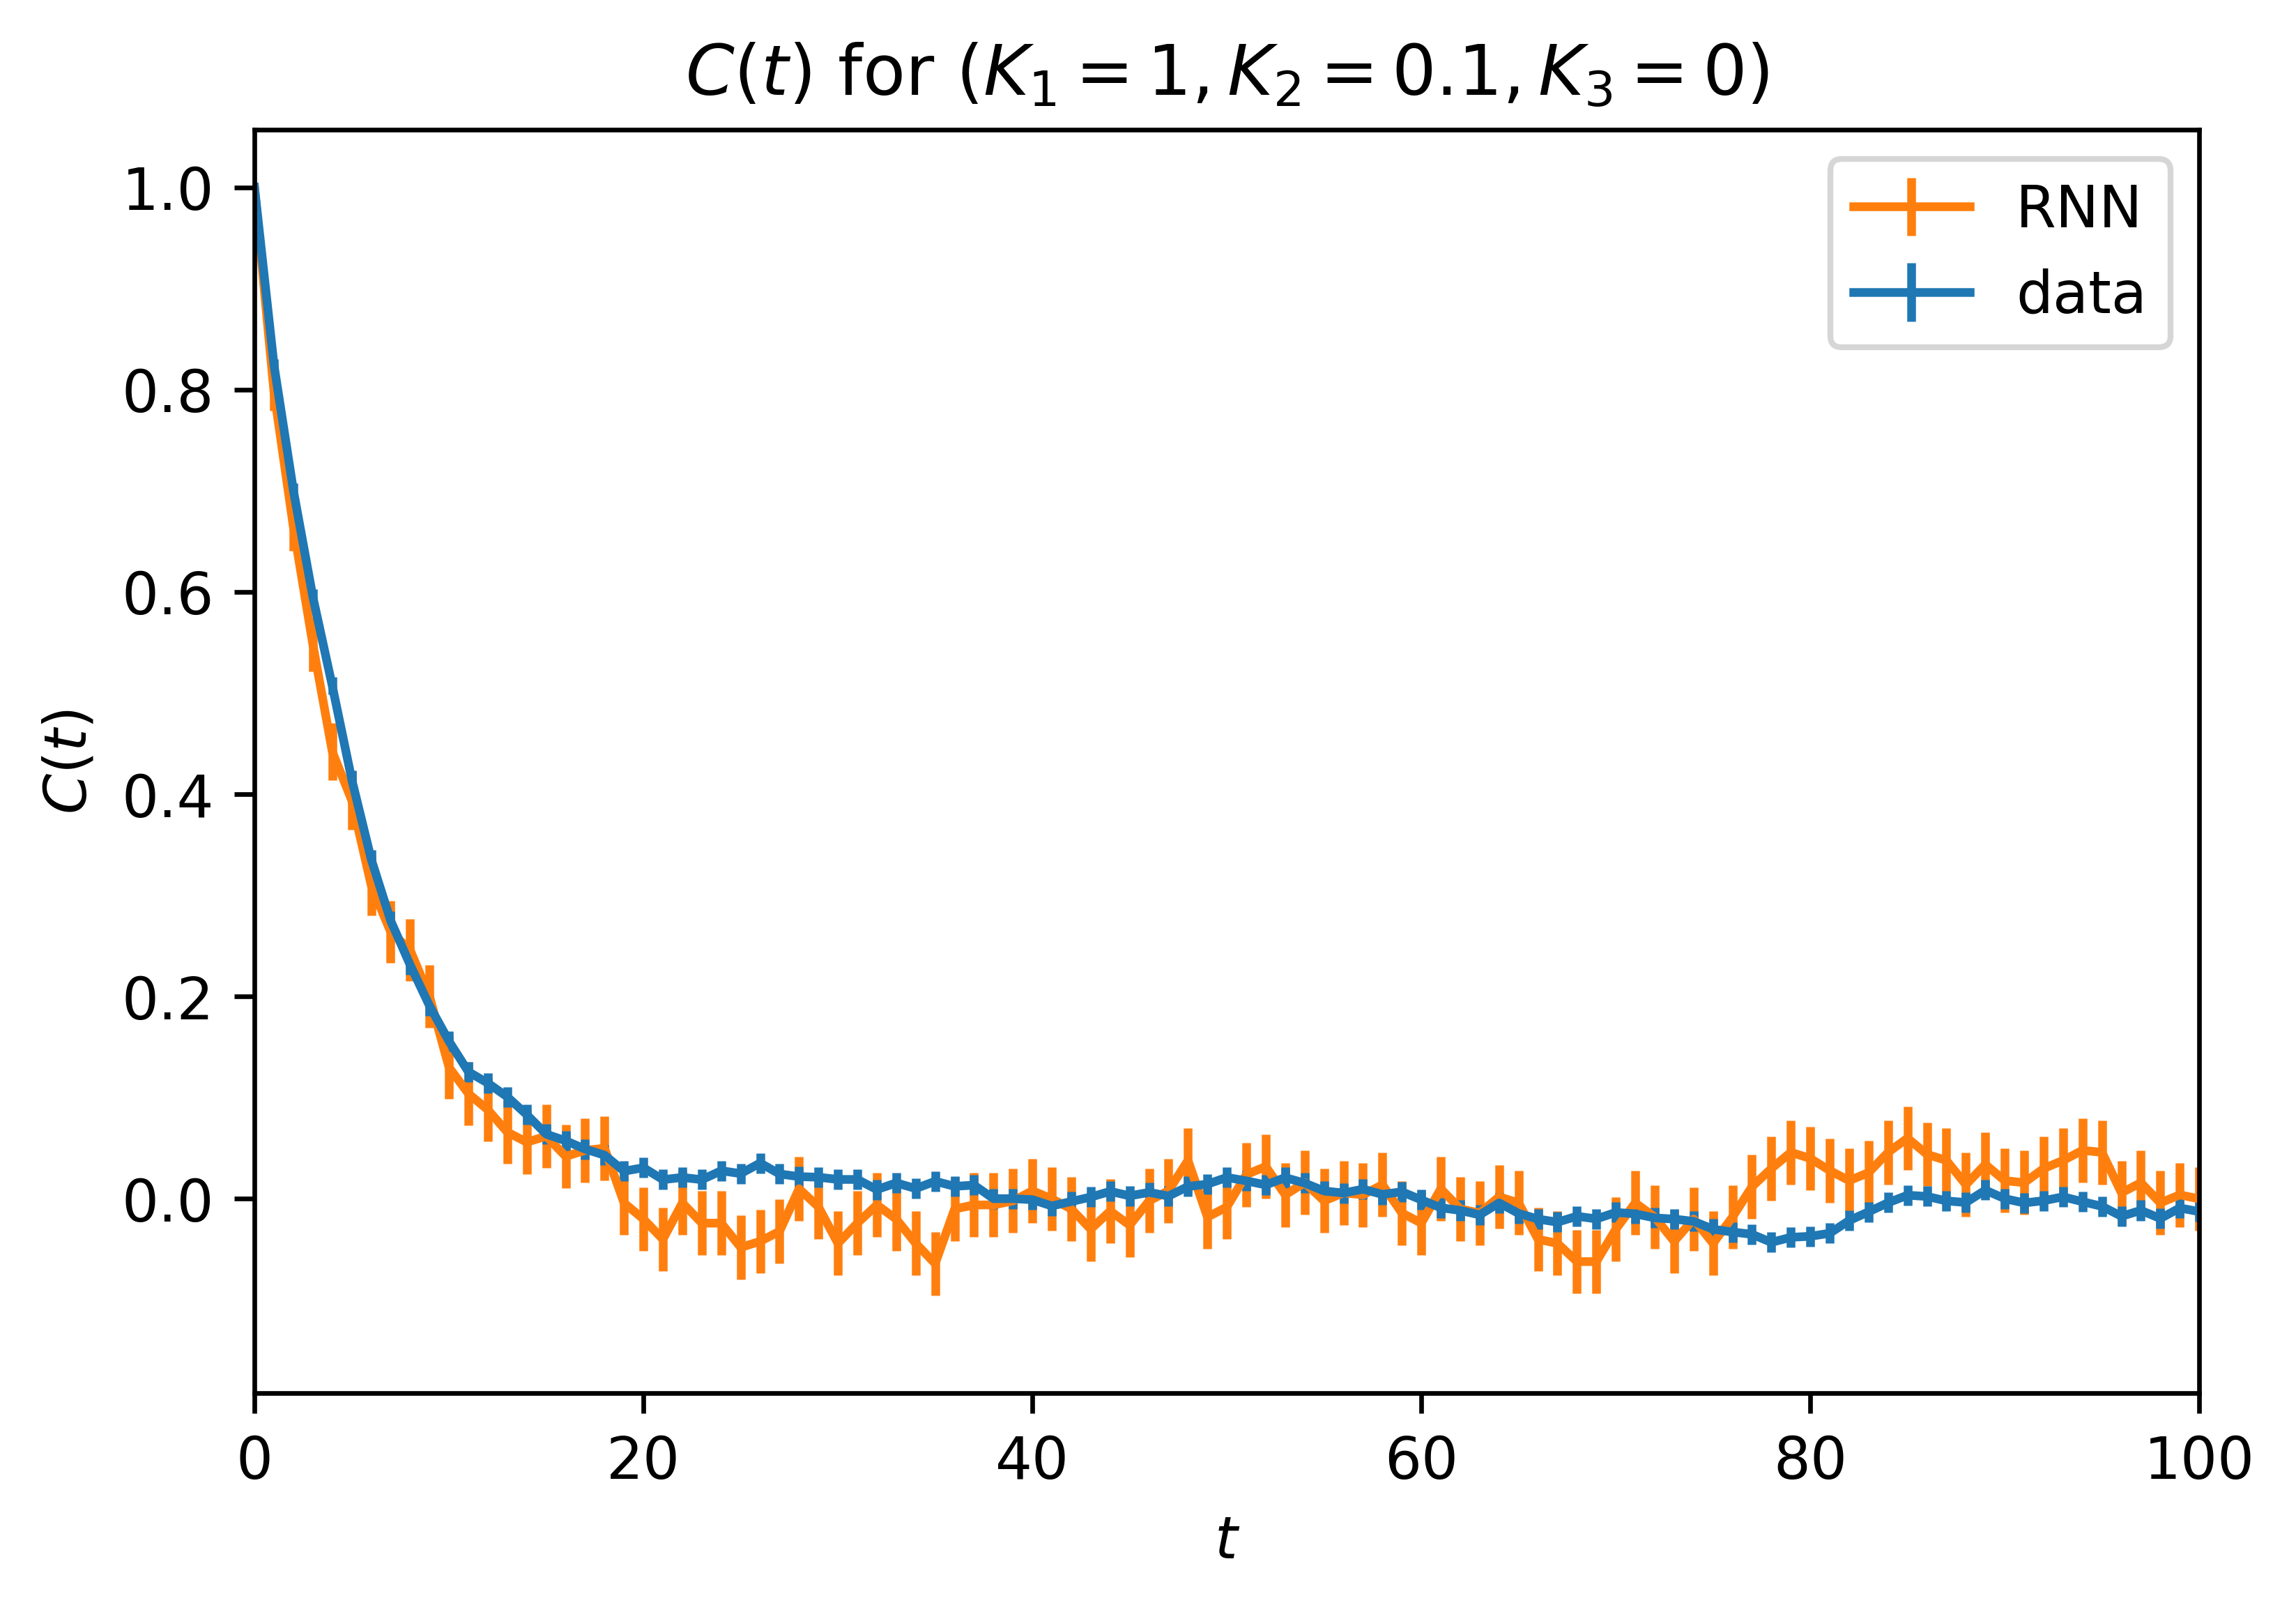

In [77]:
cmap = mpl.cm.get_cmap(name="tab10")
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6,4)
fig.set_dpi(300)
plt.title(rf"$C(t)$ for $(K_1=1, K_2=0.1, K_3=0)$")
plot_kwargs = {"linewidth":0.8, "marker":".", "markersize":3, "elinewidth":0.8}

plt.errorbar(np.arange(2048), cf_m, yerr=cf_e, label="RNN", c=cmap.colors[1])
plt.errorbar(np.arange(1000), mc_corr, yerr=mc_corr_e, label="data", c=cmap.colors[0])

plt.legend()
plt.ylabel(r"$C(t)$")
plt.xlabel(r"$t$")
plt.xlim([0,100])

In [82]:
interaction_K = 1.2
filename = f"cf_K={str(interaction_K)}.pickle"
model = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/1D/SR/macbook_K=1.2/hidden_size=1/version_6/checkpoints/epoch=6-step=699.ckpt")

In [83]:
cf_m, cf_e = rnn_generated_corrfunc(1000, model)
with open(filename, "wb") as f:
    pickle.dump((cf_m, cf_e), f)

100%|██████████| 1000/1000 [02:03<00:00,  8.07it/s]


In [84]:
interaction_K = 1.2
mc_data = np.load("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/SR/trainData_K=1.2.npz")["sampleData"]
mc_corr, mc_corr_e = mc_corrfunc(mc_data)

filename = f"cf_mc_K={str(interaction_K)}"
with open(filename, "wb") as f:
    pickle.dump((mc_corr, mc_corr_e), f)

In [3]:
with open("/Users/jesselin/Dropbox/src/thesis/final/scripts/cf_K=1.2.pickle", "rb") as f:
    cfr_12, cfr_12_e = pickle.load(f)
with open("/Users/jesselin/Dropbox/src/thesis/final/scripts/cf_K=1.pickle", "rb") as f:
    cfr_1, cfr_1_e = pickle.load(f)
with open("/Users/jesselin/Dropbox/src/thesis/final/scripts/cf_K=[1.0, 0.1, 0.0].pickle", "rb") as f:
    cfr_11, cfr_11_e = pickle.load(f)

with open("/Users/jesselin/Dropbox/src/thesis/final/scripts/cf_mc_K=1.2", "rb") as f:
    cfm_12, cfm_12_e = pickle.load(f)
with open("/Users/jesselin/Dropbox/src/thesis/final/scripts/cf_mc_K=1", "rb") as f:
    cfm_1, cfm_1_e = pickle.load(f)
with open("/Users/jesselin/Dropbox/src/thesis/final/scripts/cf_mc_K=[1.0, 0.1, 0.0]", "rb") as f:
    cfm_11, cfm_11_e = pickle.load(f)


/var/folders/ty/x496zbwx57z88dn9jdvtm8ww0000gn/T/ipykernel_58087/4112612839.py:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,100])


(0.7079812002696424, 100)

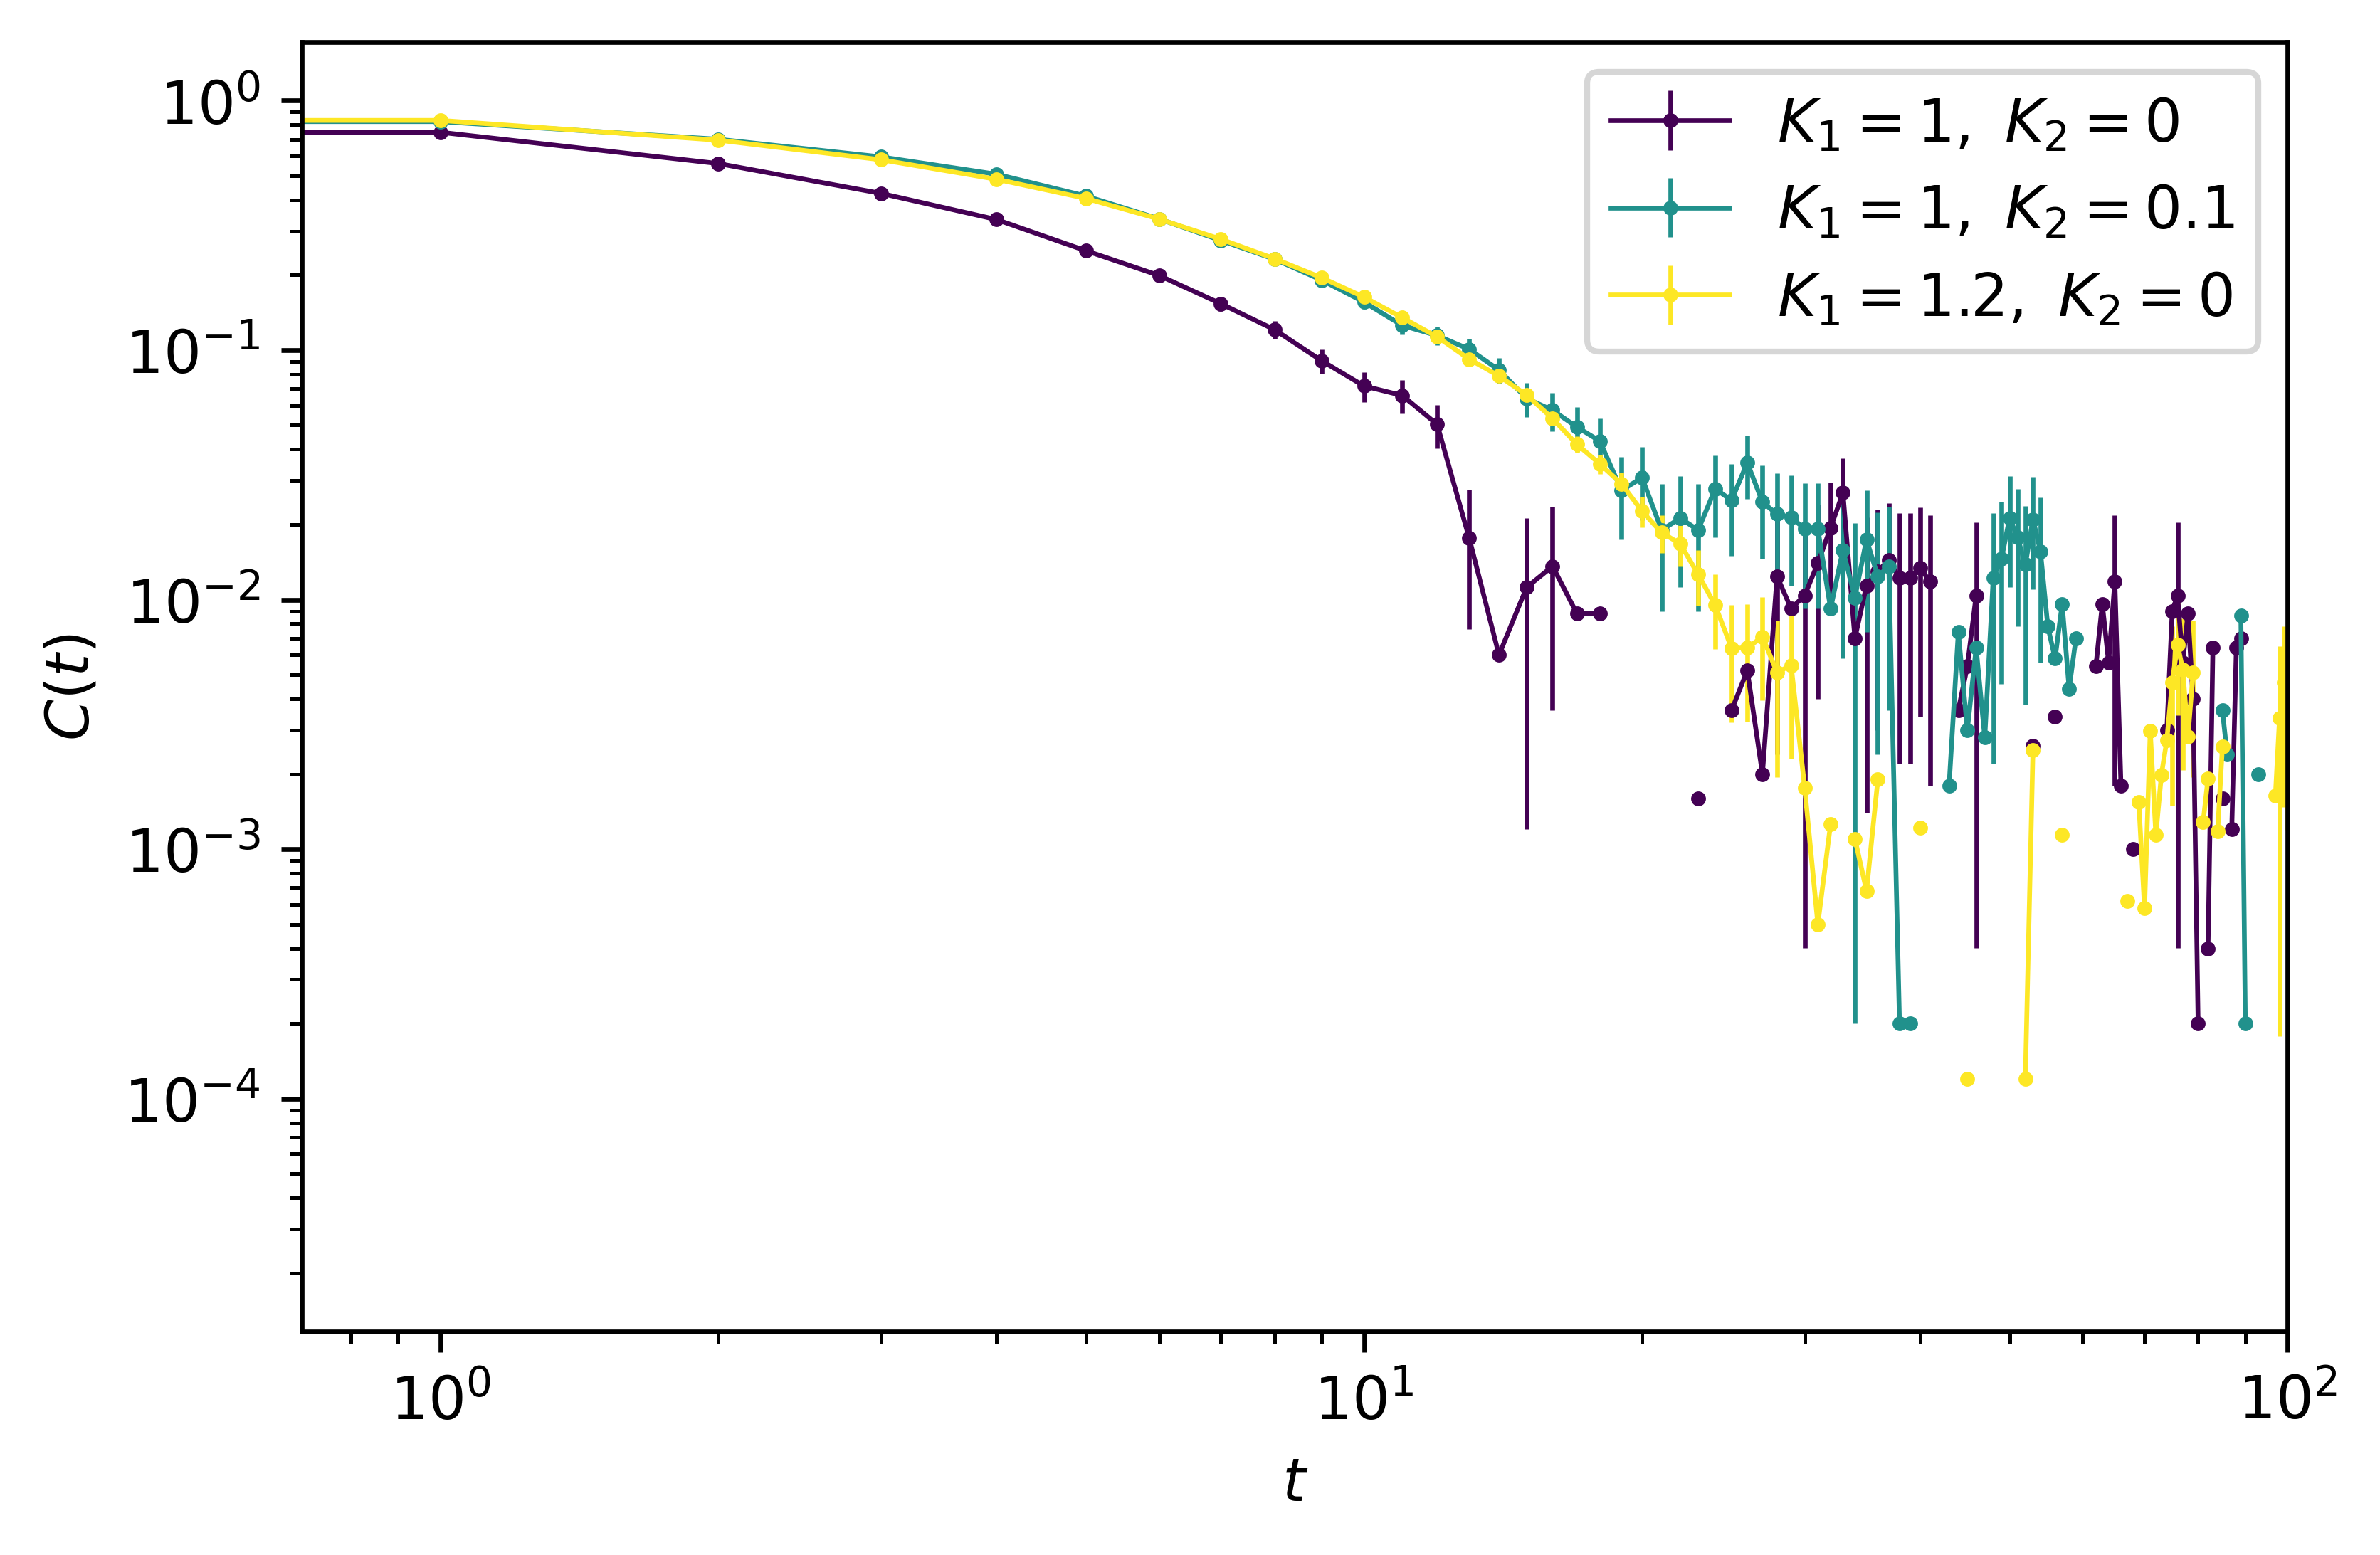

In [8]:
cmap = mpl.cm.get_cmap(name="viridis", lut=3)
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6,4)
fig.set_dpi(300)
plot_kwargs = {"linewidth":0.8, "marker":".", "markersize":3, "elinewidth":0.8}
plot_kwargs_mc = {"linestyle":"none", "marker":"^", "markersize":3, "elinewidth":0.8}

mcx = np.arange(1000)
rnx = np.arange(2048)

plt.errorbar(mcx, cfm_1, yerr=cfm_1_e, label=r"$K_1=1,\ K_2=0$", c=cmap.colors[0], **plot_kwargs)
plt.errorbar(mcx, cfm_11, yerr=cfm_11_e, label=r"$K_1=1,\ K_2=0.1$", c=cmap.colors[1], **plot_kwargs)
plt.errorbar(mcx, cfm_12, yerr=cfm_12_e, label=r"$K_1=1.2,\ K_2=0$", c=cmap.colors[2], **plot_kwargs)
plt.yscale("log", nonpositive="mask")
plt.xscale("log")

plt.legend()
plt.ylabel(r"$C(t)$")
plt.xlabel(r"$t$")
plt.xlim([0,100])


(0.0, 100.0)

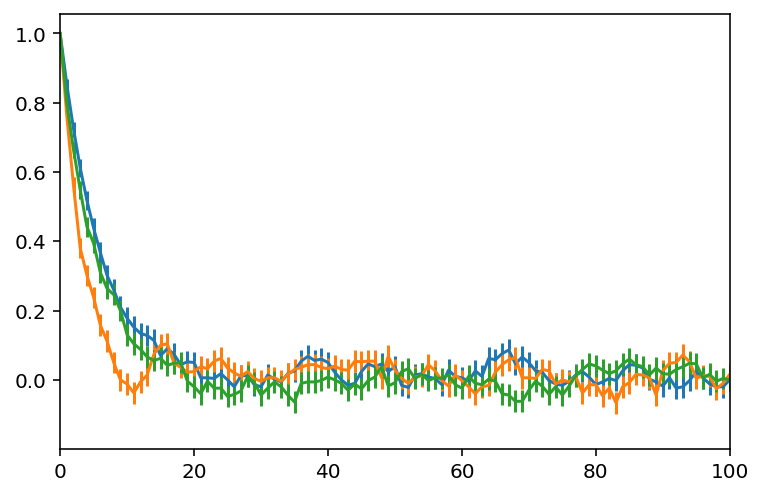

In [87]:
xdata = np.arange(2048)
plt.errorbar(xdata, cfr_12, yerr=cfr_12_e)
plt.errorbar(xdata, cfr_1, yerr=cfr_1_e)
plt.errorbar(xdata, cfr_11, yerr=cfr_11_e)
plt.xlim([0,100])